# Transfer Learning for Image Classification in PyTorch

How a CNN learns ([source](https://developer.nvidia.com/discover/convolutional-neural-network)):

![cnn-learning](https://developer.nvidia.com/sites/default/files/pictures/2018/convolutional_neural_network.png)

Layer visualization ([source](https://medium.com/analytics-vidhya/deep-learning-visualization-and-interpretation-of-neural-networks-2f3f82f501c5)):

![cnn-learning](https://miro.medium.com/max/1610/1*WysCJ6Ynecvviwctt6WDlQ.png)


In [29]:
!pip install opendatasets --upgrade

Requirement already up-to-date: opendatasets in /usr/local/lib/python3.7/dist-packages (0.1.10)


In [30]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [31]:
project_name='classification-model-for-covid-19-radiography-dataset'

## Downloading the Dataset

We'll use the COVID Face Mask Detection Dataset dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database. *COVID-19 CHEST X-RAY DATABASE

This COVID-19, normal and other lung infection dataset is released in stages. In the first release we have released 219 COVID-19, 1341 normal and 1345 viral pneumonia chest X-ray (CXR) images. In the first update, we have increased the COVID-19 class to 1200 CXR images. In the 2nd update, we have increased the database to 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images. We will continue to update this database as soon as we have new x-ray images for COVID-19 pneumonia patients.

In [32]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/tawsifurrahman/covid19-radiography-database'
od.download(dataset_url)

  1%|          | 5.00M/745M [00:00<00:17, 43.6MB/s]

100%|██████████| 745M/745M [00:03<00:00, 257MB/s]


In [33]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    for images, labels in dl:
        #print(images.shape)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
class Start:
  def __init__(self,name):
    # Look into the data directory
    self.data_dir = name
    #print(os.listdir(data_dir))
    # transform all the images into tensors
    self.dataset=ImageFolder(self.data_dir,tt.ToTensor())
    classes = self.dataset.classes
    print(classes)
    print('Length of Dataset : ',len(self.dataset))
  
  def image_size(self):
    #checking the size of the first 10 images in the dataset

    im_count = 0
    for image,_ in self.dataset:
      im_count += 1
      print(image.shape)
      if im_count == 5:
        break  

    #checking the maximum and minimum size of the images of the whole dataset
    height = []
    width = []
    for image,_ in self.dataset:
      height.append(image.shape[1])
      width.append(image.shape[2])
    print("minimum height: {}, maximum height: {}, minimum width: {}, maximum width: {}".format(min(height), max(height), min(width), max(width)))
    self.H=min(height)
    self.W=min(width)

  

  def transform_data(self):
    # Data transforms (normalization & data augmentation)
    self.stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

    train_tfms = tt.Compose([tt.Resize((100, 100)),
                              tt.RandomCrop(100, padding=1, padding_mode='reflect'), 
                              tt.RandomHorizontalFlip(),
                              tt.RandomRotation(degrees=15),
                              tt.ToTensor(),
                              tt.Normalize(*self.stats,inplace=True)])
      # test_tfms = tt.Compose([tt.Resize((self.H, self.W)),
      #                     tt.RandomResizedCrop(min(self.H,self.W)),
      #                     tt.ToTensor(), tt.Normalize(*stats)])
      #}
      
    self.dataset = ImageFolder(self.data_dir, train_tfms)


    
  def divide_dataset(self):
    
    random_seed = 42
    torch.manual_seed(random_seed);
    TRAIN = 0.7
    TEST = 0.15
    VAL = 0.15

    train_size = int(TRAIN * len(self.dataset))
    rem_size = len(self.dataset) - train_size
    valid_size = int(VAL * len(self.dataset))
    test_size = rem_size - valid_size

    self.train_ds, self.valid_ds, self.test_ds = random_split(self.dataset, [train_size, valid_size, test_size])
    print(len(self.train_ds), len(self.valid_ds), len(self.test_ds))
    
    batch_size = 50

    # PyTorch data loaders
    self.train_dl = DataLoader(self.train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
    self.valid_dl = DataLoader(self.valid_ds, batch_size*2, num_workers=3, pin_memory=True)
    self.test_dl = DataLoader(self.test_ds, batch_size*2, num_workers=3, pin_memory=True)

In [38]:
start=Start('/content/covid19-radiography-database/COVID-19_Radiography_Dataset')

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
Length of Dataset :  21165


In [39]:
start.transform_data()

In [40]:
start.divide_dataset()

14815 3174 3176


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
dataset=start.dataset
train_dl=start.train_dl
valid_dl=start.valid_dl
test_dl=start.test_dl

In [42]:
print(dataset.classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [43]:
img, label = dataset[1542]
print(img.shape, label)
img

torch.Size([3, 100, 100]) 0


tensor([[[-2.4291, -2.4291, -2.4291,  ..., -1.6149, -1.6343, -2.4291],
         [-1.7118, -1.5955, -1.3435,  ..., -1.6343, -1.6343, -2.4291],
         [-1.6924, -1.7312, -1.7894,  ..., -1.6343, -1.6537, -2.4291],
         ...,
         [-2.4291,  0.0328, -0.2192,  ..., -2.0026, -1.2854, -0.3743],
         [-2.4291,  0.0522, -0.2192,  ..., -2.1383, -2.1771, -1.2660],
         [-2.4291,  0.0716, -0.1998,  ..., -2.4291, -2.4291, -2.4291]],

        [[-2.4183, -2.4183, -2.4183,  ..., -1.5922, -1.6119, -2.4183],
         [-1.6906, -1.5726, -1.3169,  ..., -1.6119, -1.6119, -2.4183],
         [-1.6709, -1.7102, -1.7692,  ..., -1.6119, -1.6316, -2.4183],
         ...,
         [-2.4183,  0.0794, -0.1762,  ..., -1.9856, -1.2579, -0.3336],
         [-2.4183,  0.0991, -0.1762,  ..., -2.1233, -2.1626, -1.2382],
         [-2.4183,  0.1188, -0.1566,  ..., -2.4183, -2.4183, -2.4183]],

        [[-2.2214, -2.2214, -2.2214,  ..., -1.4020, -1.4215, -2.2214],
         [-1.4995, -1.3825, -1.1288,  ..., -1

In [44]:
device = get_default_device()
device

device(type='cuda')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


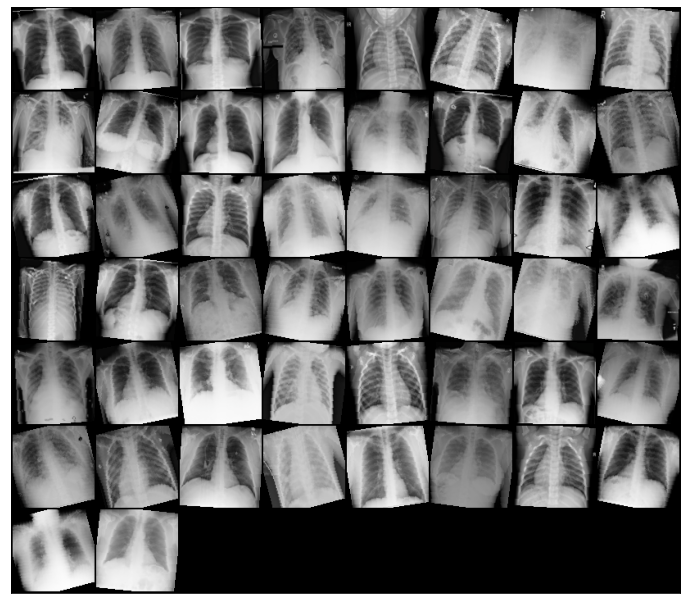

In [45]:
show_batch(train_dl)

In [46]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Modifying a Pretrained Model (ResNet18)

Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)


In [47]:
from torchvision import models

class ResNet18(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        #self.network = models.vgg16(pretrained=pretrained)
        self.network = models.resnet18(pretrained=pretrained)
        #self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
        # num_ftrs = self.network.classifier[6].in_features
        # self.network.classifier[6] = nn.Linear(num_ftrs,num_classes)

    def forward(self, xb):
        return self.network(xb)

In [48]:
#transfer_learning
transfer_model = to_device(ResNet18(len(dataset.classes)), device)

In [49]:
model=transfer_model

In [50]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.06896959990262985, 'val_loss': 1.9445124864578247}]

In [52]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [53]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00602, train_loss: 0.5777, val_loss: 6.1450, val_acc: 0.3033
Epoch [1], last_lr: 0.00994, train_loss: 0.5850, val_loss: 0.6314, val_acc: 0.7632
Epoch [2], last_lr: 0.00812, train_loss: 0.4640, val_loss: 0.9356, val_acc: 0.7295
Epoch [3], last_lr: 0.00463, train_loss: 0.3725, val_loss: 0.3603, val_acc: 0.8590
Epoch [4], last_lr: 0.00133, train_loss: 0.2972, val_loss: 0.2549, val_acc: 0.9094
Epoch [5], last_lr: 0.00000, train_loss: 0.2278, val_loss: 0.2294, val_acc: 0.9194
CPU times: user 44.5 s, sys: 5.85 s, total: 50.3 s
Wall time: 4min 20s


In [55]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

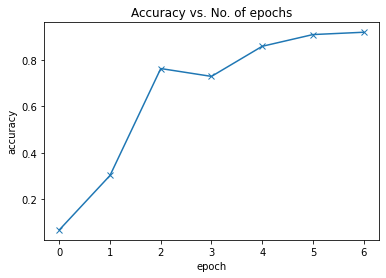

In [56]:
plot_accuracies(history)

In [57]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

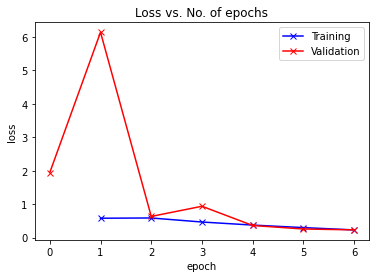

In [58]:
plot_losses(history)

In [59]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

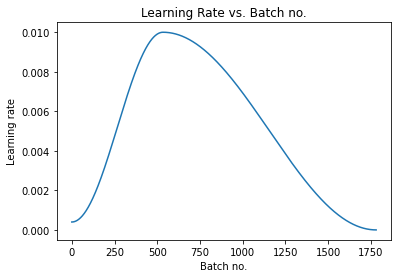

In [60]:
plot_lrs(history)

In [61]:
# Check Accuracy for test dataset
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.9114802479743958, 'val_loss': 0.23607981204986572}

## Training a model from scratch 

Let's repeat the training without using pretrained ResNet18 model. Here we will use an own defined cnn-model for training purpose. 

In [66]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) # 64 * 100 * 100
        self.conv2 = conv_block(64, 128, pool=True) # 128 * 50 * 50
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 * 25 * 25
        self.conv4 = conv_block(256, 512, pool=True) # 512 * 12 * 12
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 728, pool=True) # 728 * 6 * 6
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), # 728 * 1 * 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(728, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        #print('1', out.shape)
        out = self.conv2(out)
        #print('2', out.shape)
        out = self.res1(out) + out
        #print('3', out.shape)
        out = self.conv3(out)
        #print('4', out.shape)
        out = self.conv4(out)
        #print('5', out.shape)
        out = self.res2(out) + out
        #print('6', out.shape)
        out = self.conv5(out)
        #print('7', out.shape)
        out = self.classifier(out)
        #print('8', out.shape)
        return out

In [67]:
cnn_model = to_device(ResNet9(3, len(dataset.classes)), device)
model=cnn_model

In [68]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.2670692503452301, 'val_loss': 1.3798177242279053}]

In [69]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [70]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00602, train_loss: 0.9380, val_loss: 0.8690, val_acc: 0.6537
Epoch [1], last_lr: 0.00994, train_loss: 0.9349, val_loss: 0.8584, val_acc: 0.7010
Epoch [2], last_lr: 0.00812, train_loss: 0.6761, val_loss: 2.3092, val_acc: 0.5275
Epoch [3], last_lr: 0.00463, train_loss: 0.5158, val_loss: 0.5178, val_acc: 0.7976
Epoch [4], last_lr: 0.00133, train_loss: 0.3866, val_loss: 0.3097, val_acc: 0.8819
Epoch [5], last_lr: 0.00000, train_loss: 0.2832, val_loss: 0.2625, val_acc: 0.9066
CPU times: user 3min 28s, sys: 3min 36s, total: 7min 5s
Wall time: 7min 48s


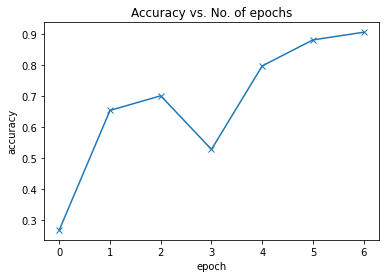

In [72]:
plot_accuracies(history)

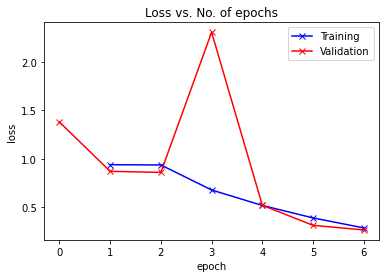

In [73]:
plot_losses(history)

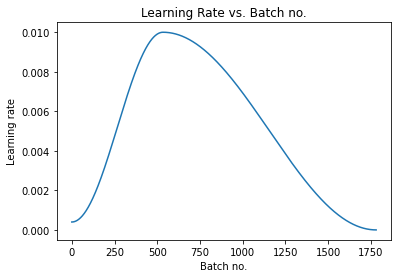

In [74]:
plot_lrs(history)

In [75]:
# test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.9033717513084412, 'val_loss': 0.26912856101989746}

###Here we get almost same accuracy compare to the pre-trained model in 2x times.